In [1]:
from asterixdb.asterixdb import AsterixConnection
import json
from glob import glob
import os
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
con = AsterixConnection(server='http://localhost', port=19002)

1. What is the temporal distribution of posts/claims and reviewed posts?
    - Look more into Jan + Nov 2017 (joint spikes)
- Which topics are more prominent in join?
- Which subreddits are more prominent in join?
- Who posts the most claims?
- Which claims have the most posts?
- Which posts are the most commented?
- Which posts are the highest scoring?

# Raw join

In [3]:
# response = con.query('''
#     USE FactMap;
    
#     SELECT u.*
#     FROM urljoin u
# ''')

In [4]:
response = con.query('''
    USE FactMap;
    
    SELECT u.*
    FROM fuzzyurljoin u
''')

In [5]:
matched = response.results
len(matched)

8202

Load raw join data:

In [6]:
# path = "/Users/anders1991/Github/FactMap/Data/raw_join.json"
# matched = []

# with open(path, 'r') as f:
#     for line in f:
#          matched.append(json.loads(line))

# print(len(matched))

In [7]:
claims = [x['r'] for x in matched]
posts = [x['p'] for x in matched]

# 1. What is the temporal distribution of posts/claims and reviewed posts?

In [8]:
df_p = pd.DataFrame(posts)
df_p['created_utc'] = df_p['created_utc'].astype("datetime64")

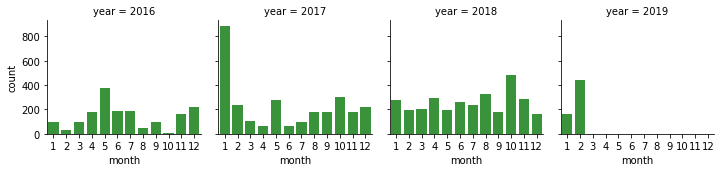

In [9]:
hist0 = pd.DataFrame(df_p['created_utc'].groupby([df_p['created_utc'].dt.year, df_p['created_utc'].dt.month]).count())
hist0.columns = ['count']
hist0.reset_index(level=1, inplace=True)
hist0.columns = ['month', 'count']
hist0.reset_index(inplace=True)
hist0.columns = ['year', 'month', 'count']

sns.catplot(data=hist0,
            x='month', 
            y='count', 
            col='year', 
            col_wrap=5,
            height=2.5,
            kind='bar',
            color='tab:green')
# plt.savefig('/Users/anders1991/Desktop/join_posts_by_datetime.png')
plt.tight_layout()

Compute date range for claims:

In [10]:
r = con.query('''
    USE FactMap;

    SELECT get_year(datetime(r.reviewDate)) as year, 
    get_month(datetime(r.reviewDate)) as month,
    count(*) as count
    FROM reviews r
    GROUP BY get_year(datetime(r.reviewDate)), get_month(datetime(r.reviewDate))
    ORDER BY
    get_year(datetime(r.reviewDate)), get_month(datetime(r.reviewDate));
    ''')

In [11]:
hist1 = pd.DataFrame(r.results)
hist1.fillna('-1', inplace=True)
hist1['year'] = hist1['year'].astype(int)
hist1['month'] = hist1['month'].astype(int)
hist1['count'] = hist1['count'].astype(int)

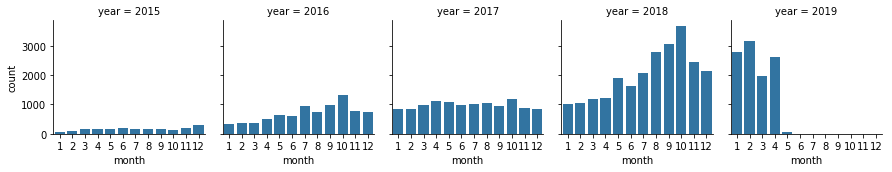

In [12]:
sns.catplot(data=hist1[hist1["year"]>=2015],
            x='month', 
            y='count', 
            col='year', 
            col_wrap=5,
            height=2.5,
            kind='bar',
            color='tab:blue')
# plt.savefig('/Users/anders1991/Desktop/reviews_by_datetime.png')
plt.tight_layout()

Compute the date range for posts:

In [13]:
r = con.query('''
    USE FactMap;

    SELECT get_year(p.created_utc) as year, 
    get_month(p.created_utc) as month,
    count(*) as count
    FROM posts p
    GROUP BY get_year(p.created_utc), get_month(p.created_utc) 
    ORDER BY
    get_year(p.created_utc), get_month(p.created_utc);
    ''')

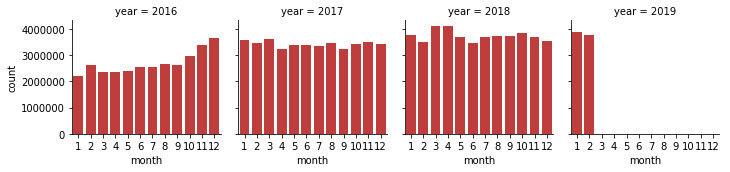

In [51]:
hist2 = pd.DataFrame(r.results)
hist2['year'] = hist2['year'].astype(int)
hist2['month'] = hist2['month'].astype(int)
hist2['count'] = hist2['count'].astype(int)

ax = sns.catplot(data=hist2,
            x='month', 
            y='count', 
            col='year', 
            col_wrap=5,
            height=2.5,
            kind='bar',
            color='tab:red')

# plt.savefig('/Users/anders1991/Desktop/posts_by_datetime.png')
plt.tight_layout()

Combined plot

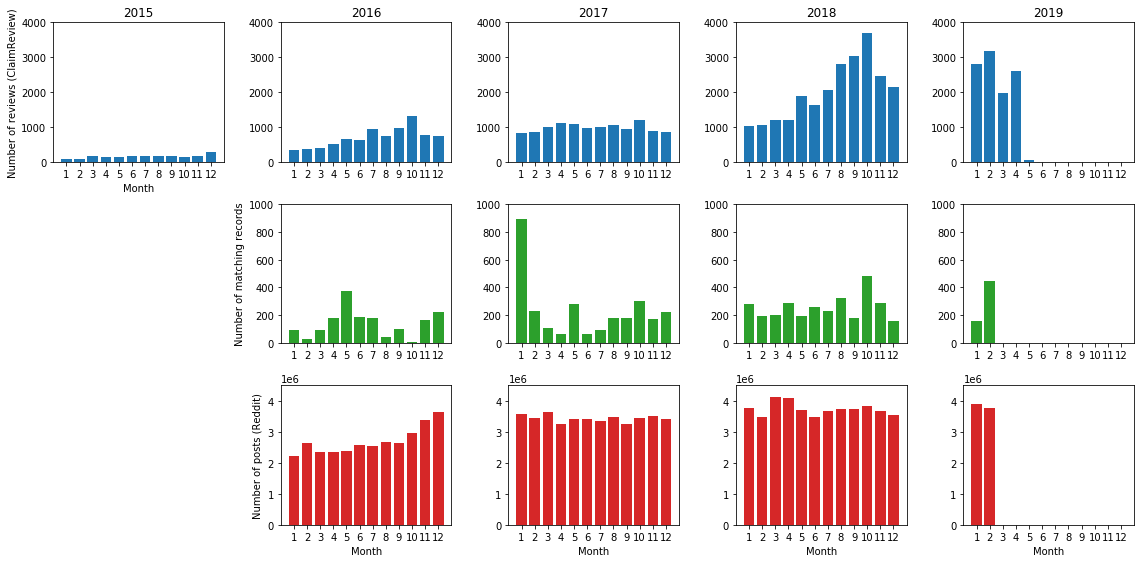

In [122]:
plt.figure(figsize=(16,8))

plt.subplot(3,5,1)
plt.bar(hist1[hist1['year']==2015]['month'], hist1[hist1['year']==2015]['count'], color='tab:blue')
plt.xlim(0,13)
plt.ylim(0, 4000)
plt.xticks(range(1,13))
plt.title('2015')
plt.xlabel("Month")
plt.ylabel("Number of reviews (ClaimReview)")

plt.subplot(3,5,2)
plt.bar(hist1[hist1['year']==2016]['month'], hist1[hist1['year']==2016]['count'], color='tab:blue')
plt.xlim(0,13)
plt.ylim(0, 4000)
plt.xticks(range(1,13))
plt.title('2016')

plt.subplot(3,5,3)
plt.bar(hist1[hist1['year']==2017]['month'], hist1[hist1['year']==2017]['count'], color='tab:blue')
plt.xlim(0,13)
plt.ylim(0, 4000)
plt.xticks(range(1,13))
plt.title('2017')

plt.subplot(3,5,4)
plt.bar(hist1[hist1['year']==2018]['month'], hist1[hist1['year']==2018]['count'], color='tab:blue')
plt.xlim(0,13)
plt.ylim(0, 4000)
plt.xticks(range(1,13))
plt.title('2018')

plt.subplot(3,5,5)
plt.bar(hist1[hist1['year']==2019]['month'], hist1[hist1['year']==2019]['count'], color='tab:blue')
plt.xlim(0,13)
plt.ylim(0, 4000)
plt.xticks(range(1,13))
plt.title('2019')

plt.subplot(3,5,7)
plt.bar(hist0[hist0['year']==2016]['month'], hist0[hist0['year']==2016]['count'], color='tab:green')
plt.xlim(0,13)
plt.ylim(0, 1000)
plt.xticks(range(1,13))
plt.ylabel("Number of matching records")

plt.subplot(3,5,8)
plt.bar(hist0[hist0['year']==2017]['month'], hist0[hist0['year']==2017]['count'], color='tab:green')
plt.xlim(0,13)
plt.ylim(0, 1000)
plt.xticks(range(1,13))

plt.subplot(3,5,9)
plt.bar(hist0[hist0['year']==2018]['month'], hist0[hist0['year']==2018]['count'], color='tab:green')
plt.xlim(0,13)
plt.ylim(0, 1000)
plt.xticks(range(1,13))

plt.subplot(3,5,10)
plt.bar(hist0[hist0['year']==2019]['month'], hist0[hist0['year']==2019]['count'], color='tab:green')
plt.xlim(0,13)
plt.ylim(0, 1000)
plt.xticks(range(1,13))

plt.subplot(3,5,12)
plt.bar(hist2[hist2['year']==2016]['month'], hist2[hist2['year']==2016]['count'], color='tab:red')
plt.xlim(0,13)
plt.ylim(0, 4500000)
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Number of posts (Reddit)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(3,5,13)
plt.bar(hist2[hist2['year']==2017]['month'], hist2[hist2['year']==2017]['count'], color='tab:red')
plt.xlim(0,13)
plt.ylim(0, 4500000)
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(3,5,14)
plt.bar(hist2[hist2['year']==2018]['month'], hist2[hist2['year']==2018]['count'], color='tab:red')
plt.xlim(0,13)
plt.ylim(0, 4500000)
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(3,5,15)
plt.bar(hist2[hist2['year']==2019]['month'], hist2[hist2['year']==2019]['count'], color='tab:red')
plt.xlim(0,13)
plt.ylim(0, 4500000)
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.savefig('join_distribution.png', bbox_inches='tight')
plt.tight_layout()

## 1a. Look more into Jan 2017 (spike)

In [17]:
def str2Date(stringdate):
    date = datetime.strptime(stringdate, '%Y-%m-%dT%H:%M:%S.%fZ')
    return date

In [18]:
c2017_1 = []

for c in claims:
    if c['claimDate']:
        dt = str2Date(c['claimDate'])
        if dt.year == 2017 and dt.month == 1:
            c2017_1.append(c)
            
print('1/2017:', len(c2017_1))

1/2017: 225


# topics in 1/2017: 1360

Donald Trump                176
Fact checking               154
Fact                        132
United States of America     52
Company                      44
Tax                          44
Democratic Party             30
Health law                   22
Country                      22
Business                     22
dtype: int64



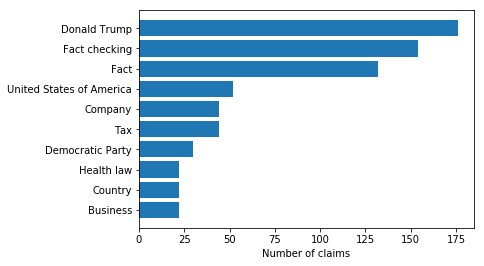

Claims:


{'"Mostly Democrat states refused to hand over data" that could show election fraud.',
 "A Trump hotel’s revenue from a foreign government would not violate the Constitution's emoluments clause.",
 'Mr. Trump said he could legally run his business and serve as president.',
 'Mr. Trump said he used to hold news conferences almost daily.',
 "Mr. Trump said most Americans don't care that he hasn't released his tax returns.",
 'Mr. Trump said “a lot of car companies are going to be moving in” and that other industries will follow.',
 'The Affordable Care Act is “imploding.” Congress should repeal the health law and replace it at about the same time.',
 'The Republican National Committee was not hacked because it had better defenses than the Democrats.',
 '“There will be a major border tax on these companies that are leaving and getting away with murder.”'}

In [21]:
topics17_1 = []
for c in c2017_1:
    for t in c['tagsNamed']:
        topics17_1.append(t['keyword'])

print('# topics in 1/2017:', len(topics17_1))
print()

jan17_top10 = pd.Series(topics17_1).value_counts().nlargest(10)
print(jan17_top10)
print()

plt.barh(jan17_top10.index, jan17_top10, color='tab:blue')
plt.gca().invert_yaxis()
plt.xlabel('Number of claims')
# plt.savefig('/Users/anders1991/Desktop/topics_jan17.png', bbox_inches='tight')
plt.show()

# Inauguration of Trump (20/1/2017)
# Trump tax returns
# Republican National Committee hacking
# Border tax on companies leaving the US

jan17_stories = set()
for c in c2017_1:
    for t in c['tagsNamed']:
        if t['keyword'] in list(jan17_top10.index):
            jan17_stories.add(c['claimReviewed'])
print('Claims:')
jan17_stories

# 2. Which topics are more prominent in join?

In [22]:
tpc = dict()

for m in matched:
    for t in m['r']['tagsNamed']:
        if t['keyword'] in tpc.keys():
            tpc[t['keyword']] += 1
        else:
            tpc[t['keyword']] = 1

print('Num topics found in ClaimReviews:\t', len(tpc))

top_tpc = sorted(tpc, key=tpc.get, reverse=True)[:10]

for c in top_tpc:
    print(c, tpc[c])

Num topics found in ClaimReviews:	 1917
Donald Trump 1096
United States of America 867
Democratic Party 502
Fact 454
The White House 413
Fact checking 402
Republican Party 361
Hillary Clinton 321
Barack Obama 320
Tax 305


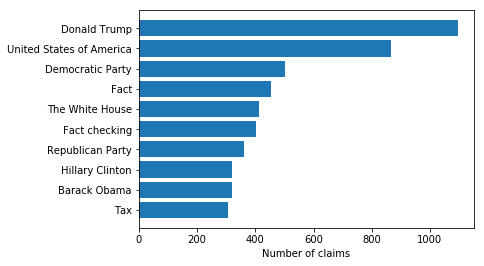

In [23]:
plt.barh(top_tpc, [tpc[c] for c in top_tpc], color='tab:blue')
plt.gca().invert_yaxis()
plt.xlabel('Number of claims')
# plt.savefig('/Users/anders1991/Desktop/top_topics.png', bbox_inches='tight')
plt.show()

# 3. Which subreddits are more prominent in join?

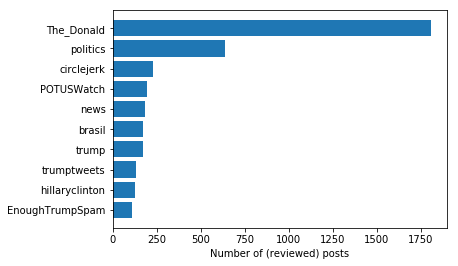

In [24]:
top_subs = df_p.groupby('subreddit').count()['id'].nlargest(10)
top_subs = pd.DataFrame(top_subs).reset_index()
top_subs.columns = ['subreddit', 'count']

plt.barh(top_subs['subreddit'], top_subs['count'])
plt.gca().invert_yaxis()
plt.ylabel('')
plt.xlabel('Number of (reviewed) posts')
# plt.savefig('/Users/anders1991/Desktop/top_subreddits.png', bbox_inches='tight')
plt.show()

# 4. Which source URL domains are more prominent in join?

domain
donaldjtrump.com    1958
whitehouse.gov      1657
twitter.com         1384
youtube.com          332
foxnews.com          209
cnn.com              208
usatoday.com         157
nytimes.com          130
yournewswire.com     102
bbc.com               99
Name: id, dtype: int64


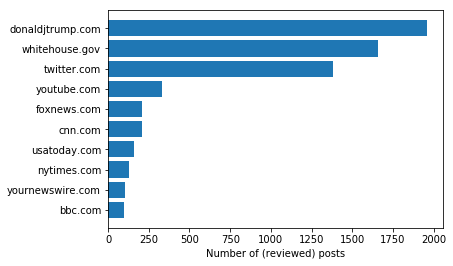

In [25]:
freq = df_p.groupby(['domain']).count()
top_domains = freq.sort_values(by='id', ascending=False)['id'].nlargest(10)
print(top_domains)

plt.barh(top_domains.index, top_domains)
plt.gca().invert_yaxis()
plt.ylabel('')
plt.xlabel('Number of (reviewed) posts')
# plt.savefig('/Users/anders1991/Desktop/top_domains.png', bbox_inches='tight')
plt.show()

# 5. Who posts the most of the reviewed claims?

author
[deleted]            1395
BirdieBroBot          259
News_Release_Bot      157
rTrumpTweetsBot       133
thefeedbot             93
Usa_redrix             89
stargazingtrek         89
DDays                  89
Dances_with_Slavs      89
JanVincent             89
awgreen3               89
soalone34              89
KilKidd                89
StrongDad1978          89
BedriddenSam           89
Name: id, dtype: int64


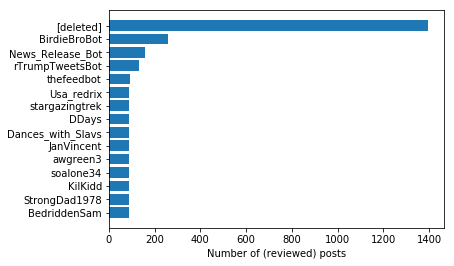

In [26]:
freq = df_p.groupby(['author']).count()
top_domains = freq.sort_values(by='id', ascending=False)['id'].nlargest(15)
print(top_domains)

plt.barh(top_domains.index, top_domains)
plt.gca().invert_yaxis()
plt.ylabel('')
plt.xlabel('Number of (reviewed) posts')
# plt.savefig('/Users/anders1991/Desktop/top_users_no_bots.png', bbox_inches='tight')
plt.show()

# 6. Which posts are the most commented?

In [27]:
top_comments = df_p.drop_duplicates().nlargest(10, 'num_comments')
top_comments = top_comments[['author', 'subreddit', 'domain', 'title', 'num_comments']]
top_comments

,author,subreddit,domain,title,num_comments
2736,T-Rex_Is_best,television,youtube.com,Jimmy Kimmel on Mass Shooting in Las Vegas,8007
3278,Obandigo,news,apnews.com,Senate panel receives FBI report on Kavanaugh,5041
1055,ipgof,movies,nytimes.com,"Asia Argento, Who Accused Weinstein, Made Deal...",3300
3539,speckz,politics,washingtonexaminer.com,Trump's tariffs now cost Americans more than O...,2842
3310,Faefyre,politics,huffingtonpost.com,NRA Convention Bans Guns To Protect Mike Pence...,2818
7015,PutinsPawn,politics,thinkprogress.org,Brett Kavanaugh said he would kill Roe v. Wade...,1878
128,i_am_team_stark,dataisbeautiful,tylervigen.com,The useless correlation between US spending on...,1440
955,firststate007,The_Donald,twitter.com,"Just out — in Arizona, SIGNATURES DON’T MATCH....",1264
1640,slakmehl,politics,docs.house.gov,RE: Correcting the Record - The Russia Investi...,1242
3300,bipolar_sky_fairy,atheism,lgbtqnation.com,Republicans vote to make it legal nationwide t...,1228


# 7. Which posts are the highest scoring?

In [28]:
top_comments = df_p.drop_duplicates().nlargest(10, 'score')
top_comments = top_comments[['author', 'subreddit', 'domain', 'title', 'score']]
top_comments

,author,subreddit,domain,title,score
3539,speckz,politics,washingtonexaminer.com,Trump's tariffs now cost Americans more than O...,43697
7015,PutinsPawn,politics,thinkprogress.org,Brett Kavanaugh said he would kill Roe v. Wade...,32095
128,i_am_team_stark,dataisbeautiful,tylervigen.com,The useless correlation between US spending on...,26719
3310,Faefyre,politics,huffingtonpost.com,NRA Convention Bans Guns To Protect Mike Pence...,23699
2736,T-Rex_Is_best,television,youtube.com,Jimmy Kimmel on Mass Shooting in Las Vegas,19782
5186,XoT3K,funny,alternative-science.com,Elon Musk Offers To Buy And Then Delete Facebook,19113
1055,ipgof,movies,nytimes.com,"Asia Argento, Who Accused Weinstein, Made Deal...",15214
5509,muggerfugger,The_Donald,twitter.com,"""Pocahontas (the bad version), sometimes refer...",13657
1888,BiblicalGodlike,politics,abcnews.go.com,"Maria Butina, accused Russian agent, reaches p...",13015
955,firststate007,The_Donald,twitter.com,"Just out — in Arizona, SIGNATURES DON’T MATCH....",12891


# 8. Which claims have the most posts?

In [31]:
response = con.query('''
    USE FactMap;

    SELECT uid as _uid, url as _url, (SELECT u.p.subreddit, u.p.title FROM x) as posts, array_count(x) as cnt
    FROM fuzzyurljoin u
    GROUP BY u.r.uid AS uid, r.claimAuthor.claimURL as url
    GROUP AS x
    ORDER BY cnt DESC
    LIMIT 10;
''')

top_claims = response.results
top_claims[0]

{'_uid': '8907eae5-7ef2-4c1a-7507-16da7d6fa025',
 '_url': 'https://www.nytimes.com/2018/08/19/us/asia-argento-assault-jimmy-bennett.html',
 'cnt': 89,
 'posts': [{'subreddit': 'MensRights',
   'title': 'Asia Argento, Who Accused Weinstein, Made Deal With Her Own Accuser'},
  {'subreddit': 'The_Donald',
   'title': 'Trump Curse Strikes Again! Asia Argento Paid Off Her Own Accuser'},
  {'subreddit': 'WeinsteinEffect',
   'title': 'Asia Argento, Who Accused Weinstein, Made Deal With Her Own Accuser'},
  {'subreddit': 'Nicegirls',
   'title': 'Asia Argento is a pedophile, Who Accused Weinstein, Made Deal With Her Own Accuser'},
  {'subreddit': 'TwoXChromosomes',
   'title': '#MeToo leader sexually assaults underage Jimmy Bennett and attempt to cover it up'},
  {'subreddit': 'TheDickShow', 'title': 'NSFW: Not being a hypocrite.'},
  {'subreddit': 'Feminism',
   'title': 'Asia Argento, Who Accused Weinstein, Made Deal With Her Own Accuser'},
  {'subreddit': 'OneY', 'title': 'Reminder of how 